# Flask 웹에서 자동 수집 → 전처리 → 학습 → 시각화까지 자동화
```
전체 구조 흐름 (파이프라인)
csharp
복사
편집
[1] API 자동 수집 (1시간마다)
     ↓
[2] CSV 저장 (갱신)
     ↓
[3] 전처리 (장마/건기 분리 + 결측 제거 등)
     ↓
[4] 모델 훈련 (분류/회귀 등)
     ↓
[5] 예측/시각화 결과 생성
     ↓
[6] Flask 웹에 반영 (예: 서울 25개구 침수 위험 등)


--------------------------------------------------------------

구현 방식 요약
단계	구현 예	자동화 방법
1. 데이터 수집	schedule or cron	1시간마다 API로 자동 수집 (asos_collector.py)
2. 전처리	pandas 스크립트 함수화	수집 직후 rainy.csv, dry.csv 자동 생성
3. 학습/모델 저장	scikit-learn, joblib	수집 + 전처리 끝나면 자동 훈련 후 .pkl 저장
4. 시각화	matplotlib, plotly, seaborn, folium 등	모델 성능, 위험 지도, 추세 그래프 생성
5. Flask 연결	/api/update, /api/predict 등	사용자 요청 시 최신 모델 결과 제공

--------------------------------------------------------------

Flask에서 구성할 수 있는 주요 API 예
경로	기능
/api/auto_update	🔁 수집 + 전처리 + 모델 학습 자동 실행
/api/visualize	📊 성능/침수 위험 지도 등 JSON or 이미지 반환
/api/predict	🌧 특정 날짜/시간에 침수 위험 예측 반환
/dashboard	🖥 웹 UI 페이지 (시각화 포함)


백엔드 자동화 흐름 (예시)
python
복사
편집
@app.route('/api/auto_update', methods=['POST'])
def auto_update():
    # 1. 수집
    job()  # asos_collector.py에 있는 수집 함수

    # 2. 전처리
    preprocess_data()  # rainy.csv, dry.csv 생성

    # 3. 모델 훈련
    model = train_model('rainy.csv')  # 예: RandomForestClassifier
    joblib.dump(model, 'rainy_model.pkl')

    # 4. 시각화
    generate_performance_plot(model)
    generate_flood_risk_map()

    return jsonify({'status': '완료', 'message': '모든 단계 자동 실행 완료'})
    
-----------------------------------------------------------------------------------

가능 시각화 예
시각화 종류	라이브러리
침수 위험 지도	folium, plotly, seaborn, matplotlib
모델 성능 그래프	matplotlib, seaborn
시간별 강수량 그래프	plotly interactive
모델 비교 막대차트	/api/model_compare로 구현 가능
    
필요한 요소들
기술 요소	설명
Flask	백엔드 서버
joblib or pickle	모델 저장 및 재사용
schedule, threading, APScheduler	백그라운드 자동 스케줄링
matplotlib, plotly, folium	시각화
pandas, scikit-learn	전처리 및 모델 훈련

------------------------------------------------------------------------------------

최종 목표: “자동 침수 예측 웹 시스템”
서울 25개구 실시간 위험 예측

지도 기반 시각화 + 레벨 표시

자동 학습 및 업데이트

모델 성능 모니터링 대시보드

```

In [1]:
pip install requests pandas schedule

Note: you may need to restart the kernel to use updated packages.


# api key 활용 및 데이터 수집

In [2]:
import os
from dotenv import load_dotenv
OPENWEATHER_API_KEY = load_dotenv('.env')
OPENWEATHER_API_KEY = os.getenv('OPENWEATHER_API_KEY')
# print(os.getenv('OPENWEATHER_API_KEY'))

# ASOS 시간별 자료 수집

In [5]:
import os
import time
import requests
import pandas as pd
import datetime
import schedule

#  사용자 설정
SERVICE_KEY = OPENWEATHER_API_KEY
CSV_FILE = 'asos_seoul_hourly.csv'
STN_ID = 108
NUM_OF_ROWS = 800
API_URL = "http://apis.data.go.kr/1360000/AsosHourlyInfoService/getWthrDataList"

START_DATE = datetime.date(2020, 7, 10)
END_DATE = datetime.date.today() - datetime.timedelta(days=1)

def load_existing_times():
    if not os.path.exists(CSV_FILE):
        return set()
    df = pd.read_csv(CSV_FILE)
    return set(df['tm'].astype(str))

def fetch_day_data(date_obj, existing_times):
    """지정된 하루치(00~23시) 데이터를 수집"""
    all_results = []
    start_dt = datetime.datetime.combine(date_obj, datetime.time(0, 0))
    end_dt = datetime.datetime.combine(date_obj, datetime.time(23, 0))

    page = 1
    while True:
        params = {
            'serviceKey': SERVICE_KEY,
            'numOfRows': NUM_OF_ROWS,
            'pageNo': page,
            'dataCd': 'ASOS',
            'dateCd': 'HR',
            'startDt': start_dt.strftime("%Y%m%d"),
            'startHh': "00",
            'endDt': end_dt.strftime("%Y%m%d"),
            'endHh': "23",
            'stnIds': STN_ID,
            'dataType': 'JSON'
        }

        try:
            response = requests.get(API_URL, params=params, timeout=60)
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            print(f" [{date_obj}] 요청 실패: {e}")
            return []

        try:
            data = response.json()
            result_code = data['response']['header']['resultCode']
            result_msg = data['response']['header']['resultMsg']
            if result_code != '00':
                print(f" [{date_obj}] API 오류: {result_msg}")
                return []
        except Exception as e:
            print(f" [{date_obj}] JSON 파싱 실패")
            print(response.text[:300])
            return []

        items = data['response']['body']['items'].get('item', [])
        if not items:
            break

        for item in items:
            if item['tm'] not in existing_times:
                all_results.append(item)

        if len(items) < NUM_OF_ROWS:
            break
        page += 1

    print(f" [{date_obj}] {len(all_results)}건 수집 성공")
    return all_results

def append_to_csv(new_data):
    if not new_data:
        return
    df = pd.DataFrame(new_data)
    write_header = not os.path.exists(CSV_FILE)
    df.to_csv(CSV_FILE, mode='a', header=write_header, index=False)

def get_last_collected_date():
    if not os.path.exists(CSV_FILE):
        return START_DATE
    df = pd.read_csv(CSV_FILE)
    last_time = pd.to_datetime(df['tm']).max()
    return last_time.date() + datetime.timedelta(days=1)

def job():
    existing_times = load_existing_times()
    current_date = get_last_collected_date()

    while current_date <= END_DATE:
        new_data = fetch_day_data(current_date, existing_times)
        append_to_csv(new_data)
        current_date += datetime.timedelta(days=1)
        time.sleep(0.5)  # 과도한 요청 방지

# 최초 실행
job()

# 매시간마다 실행되도록 설정
schedule.every(1).hours.do(job)

print(" 자동 수집 대기 중...")
while True:
    schedule.run_pending()
    time.sleep(60)

 [2020-07-10] JSON 파싱 실패
<OpenAPI_ServiceResponse>
	<cmmMsgHeader>
		<errMsg>SERVICE ERROR</errMsg>
		<returnAuthMsg>SERVICE_KEY_IS_NOT_REGISTERED_ERROR</returnAuthMsg>
		<returnReasonCode>30</returnReasonCode>
	</cmmMsgHeader>
</OpenAPI_ServiceResponse>
 [2020-07-11] JSON 파싱 실패
<OpenAPI_ServiceResponse>
	<cmmMsgHeader>
		<errMsg>SERVICE ERROR</errMsg>
		<returnAuthMsg>SERVICE_KEY_IS_NOT_REGISTERED_ERROR</returnAuthMsg>
		<returnReasonCode>30</returnReasonCode>
	</cmmMsgHeader>
</OpenAPI_ServiceResponse>
 [2020-07-12] JSON 파싱 실패
<OpenAPI_ServiceResponse>
	<cmmMsgHeader>
		<errMsg>SERVICE ERROR</errMsg>
		<returnAuthMsg>SERVICE_KEY_IS_NOT_REGISTERED_ERROR</returnAuthMsg>
		<returnReasonCode>30</returnReasonCode>
	</cmmMsgHeader>
</OpenAPI_ServiceResponse>
 [2020-07-13] JSON 파싱 실패
<OpenAPI_ServiceResponse>
	<cmmMsgHeader>
		<errMsg>SERVICE ERROR</errMsg>
		<returnAuthMsg>SERVICE_KEY_IS_NOT_REGISTERED_ERROR</returnAuthMsg>
		<returnReasonCode>30</returnReasonCode>
	</cmmMsgHeader>
</OpenA

KeyboardInterrupt: 

✅ [2024-02-06] 24건 수집 성공
✅ [2024-02-07] 24건 수집 성공
✅ [2024-02-08] 24건 수집 성공
✅ [2024-02-09] 24건 수집 성공
✅ [2024-02-10] 24건 수집 성공
✅ [2024-02-11] 24건 수집 성공
✅ [2024-02-12] 24건 수집 성공
✅ [2024-02-13] 24건 수집 성공
✅ [2024-02-14] 24건 수집 성공
✅ [2024-02-15] 24건 수집 성공
✅ [2024-02-16] 24건 수집 성공
✅ [2024-02-17] 24건 수집 성공
✅ [2024-02-18] 24건 수집 성공
✅ [2024-02-19] 24건 수집 성공
✅ [2024-02-20] 24건 수집 성공
✅ [2024-02-21] 24건 수집 성공
✅ [2024-02-22] 24건 수집 성공
✅ [2024-02-23] 24건 수집 성공
✅ [2024-02-24] 24건 수집 성공
✅ [2024-02-25] 24건 수집 성공
✅ [2024-02-26] 24건 수집 성공
✅ [2024-02-27] 24건 수집 성공
✅ [2024-02-28] 24건 수집 성공
✅ [2024-02-29] 24건 수집 성공
✅ [2024-03-01] 24건 수집 성공
✅ [2024-03-02] 24건 수집 성공
✅ [2024-03-03] 24건 수집 성공
✅ [2024-03-04] 24건 수집 성공
✅ [2024-03-05] 24건 수집 성공
✅ [2024-03-06] 24건 수집 성공
✅ [2024-03-07] 24건 수집 성공
✅ [2024-03-08] 24건 수집 성공
✅ [2024-03-09] 24건 수집 성공
✅ [2024-03-10] 24건 수집 성공
✅ [2024-03-11] 24건 수집 성공
✅ [2024-03-12] 24건 수집 성공
✅ [2024-03-13] 24건 수집 성공
✅ [2024-03-14] 24건 수집 성공
✅ [2024-03-15] 24건 수집 성공
✅ [2024-03-16] 24건 수집 성공


✅ [2024-12-22] 24건 수집 성공
✅ [2024-12-23] 24건 수집 성공
✅ [2024-12-24] 24건 수집 성공
✅ [2024-12-25] 24건 수집 성공
✅ [2024-12-26] 24건 수집 성공
✅ [2024-12-27] 24건 수집 성공
✅ [2024-12-28] 24건 수집 성공
✅ [2024-12-29] 24건 수집 성공
✅ [2024-12-30] 24건 수집 성공
✅ [2024-12-31] 24건 수집 성공
✅ [2025-01-01] 24건 수집 성공
✅ [2025-01-02] 24건 수집 성공
✅ [2025-01-03] 24건 수집 성공
✅ [2025-01-04] 24건 수집 성공
✅ [2025-01-05] 24건 수집 성공
✅ [2025-01-06] 24건 수집 성공
✅ [2025-01-07] 24건 수집 성공
✅ [2025-01-08] 24건 수집 성공
✅ [2025-01-09] 24건 수집 성공
✅ [2025-01-10] 24건 수집 성공
✅ [2025-01-11] 24건 수집 성공
✅ [2025-01-12] 24건 수집 성공
✅ [2025-01-13] 24건 수집 성공
✅ [2025-01-14] 24건 수집 성공
✅ [2025-01-15] 24건 수집 성공
✅ [2025-01-16] 24건 수집 성공
✅ [2025-01-17] 24건 수집 성공
✅ [2025-01-18] 24건 수집 성공
✅ [2025-01-19] 24건 수집 성공
✅ [2025-01-20] 24건 수집 성공
✅ [2025-01-21] 24건 수집 성공
✅ [2025-01-22] 24건 수집 성공
✅ [2025-01-23] 24건 수집 성공
✅ [2025-01-24] 24건 수집 성공
✅ [2025-01-25] 24건 수집 성공
✅ [2025-01-26] 24건 수집 성공
✅ [2025-01-27] 24건 수집 성공
✅ [2025-01-28] 24건 수집 성공
✅ [2025-01-29] 24건 수집 성공
✅ [2025-01-30] 24건 수집 성공


KeyboardInterrupt: 

# 위 데이터 수집 코드 설명

In [ ]:
'''
핵심 요약
기능	설명
.env에서 API 키 불러오기	외부에 노출되지 않도록 보안 처리
하루 단위로 반복 수집	시간별 데이터 24건씩 수집
이미 수집된 데이터는 건너뜀	중복 저장 방지
API 오류/실패는 로그로 출력 후 무시	전체 흐름 끊기지 않게 설계
schedule로 1시간마다 자동 실행	실시간 운영 가능

------------------------------------------------------------------

# 필수 라이브러리 불러오기
import os
import time
import requests
import pandas as pd
import datetime
import schedule
from dotenv import load_dotenv

# .env 파일에서 환경변수(OPENWEATHER_API_KEY) 로드
OPENWEATHER_API_KEY = load_dotenv('.env')
OPENWEATHER_API_KEY = os.getenv('OPENWEATHER_API_KEY')

#  사용자 설정
SERVICE_KEY = OPENWEATHER_API_KEY  # 공공데이터포털에서 발급받은 API 키
CSV_FILE = 'asos_seoul_hourly.csv'  # 수집된 데이터를 저장할 CSV 파일명
STN_ID = 108  # 서울 지역의 지점 코드
NUM_OF_ROWS = 800  # 한 페이지당 수집할 데이터 개수 (최대 1000까지 가능)
API_URL = "http://apis.data.go.kr/1360000/AsosHourlyInfoService/getWthrDataList"  # 기상청 ASOS API URL

# 수집 기간 설정
START_DATE = datetime.date(2020, 7, 10)
END_DATE = datetime.date(2025, 7, 9)

#  기존 CSV에서 이미 수집된 시간 데이터 불러오기
def load_existing_times():
    if not os.path.exists(CSV_FILE):
        return set()  # 파일이 없으면 빈 set 반환
    df = pd.read_csv(CSV_FILE)
    return set(df['tm'].astype(str))  # 'tm' 컬럼 값을 문자열로 변환해 set으로 반환

#  하루치 데이터(00~23시) 수집 함수
def fetch_day_data(date_obj, existing_times):
    all_results = []  # 최종 수집된 item 저장 리스트
    start_dt = datetime.datetime.combine(date_obj, datetime.time(0, 0))  # 시작 시각: 자정
    end_dt = datetime.datetime.combine(date_obj, datetime.time(23, 0))  # 종료 시각: 오후 11시

    page = 1  # 페이지네이션 시작
    while True:
        # API 요청 파라미터 구성
        params = {
            'serviceKey': SERVICE_KEY,
            'numOfRows': NUM_OF_ROWS,
            'pageNo': page,
            'dataCd': 'ASOS',
            'dateCd': 'HR',
            'startDt': start_dt.strftime("%Y%m%d"),
            'startHh': "00",
            'endDt': end_dt.strftime("%Y%m%d"),
            'endHh': "23",
            'stnIds': STN_ID,
            'dataType': 'JSON'
        }

        try:
            response = requests.get(API_URL, params=params, timeout=60)  # 60초 타임아웃 설정
            response.raise_for_status()  # HTTP 오류 발생 시 예외 발생
        except requests.exceptions.RequestException as e:
            print(f" [{date_obj}] 요청 실패: {e}")
            return []  # 실패한 경우 빈 리스트 반환하여 건너뜀

        try:
            data = response.json()  # JSON 응답 파싱
            result_code = data['response']['header']['resultCode']
            result_msg = data['response']['header']['resultMsg']
            if result_code != '00':
                print(f" [{date_obj}] API 오류: {result_msg}")
                return []  # API 응답이 정상 코드가 아닌 경우 무시
        except Exception as e:
            print(f" [{date_obj}] JSON 파싱 실패")
            print(response.text[:300])  # 에러 응답 일부 출력
            return []

        items = data['response']['body']['items'].get('item', [])  # 실제 관측 데이터 리스트
        if not items:
            break  # 데이터가 없으면 종료

        # 기존에 수집되지 않은 시간만 필터링
        for item in items:
            if item['tm'] not in existing_times:
                all_results.append(item)

        if len(items) < NUM_OF_ROWS:
            break  # 더 이상 다음 페이지가 없으면 종료
        page += 1  # 다음 페이지 요청

    print(f" [{date_obj}] {len(all_results)}건 수집 성공")
    return all_results

#  새로 수집된 데이터를 CSV에 저장
def append_to_csv(new_data):
    if not new_data:
        return
    df = pd.DataFrame(new_data)
    write_header = not os.path.exists(CSV_FILE)  # 헤더는 최초 1회만 기록
    df.to_csv(CSV_FILE, mode='a', header=write_header, index=False)

#  CSV에서 마지막 수집 날짜를 확인하여 이어서 수집
def get_last_collected_date():
    if not os.path.exists(CSV_FILE):
        return START_DATE  # 파일이 없으면 START_DATE부터 시작
    df = pd.read_csv(CSV_FILE)
    last_time = pd.to_datetime(df['tm']).max()  # 가장 마지막 관측 시각
    return last_time.date() + datetime.timedelta(days=1)  # 다음 날부터 수집

#  자동 수집 작업 정의
def job():
    existing_times = load_existing_times()  # 기존 수집 시간 목록
    current_date = get_last_collected_date()  # 다음 수집 시작 날짜

    while current_date <= END_DATE:
        new_data = fetch_day_data(current_date, existing_times)  # 하루치 수집
        append_to_csv(new_data)  # CSV에 저장
        current_date += datetime.timedelta(days=1)  # 다음 날짜로 이동
        time.sleep(0.5)  # 너무 빠른 요청 방지 (0.5초 대기)

#  최초 수집 실행
job()

#  매 시간마다 job()을 자동 실행
schedule.every(1).hours.do(job)

#  무한 루프: 스케줄링된 작업 수행 대기
print(" 자동 수집 대기 중...")
while True:
    schedule.run_pending()  # 예약된 작업 실행
    time.sleep(60)  # 1분 단위로 체크
'''

In [ ]:
'''
기상청 ASOS API는 지점마다 과거 수집 가능 범위가 다름

서울(지점 108)은 2000년대 이후 대부분 커버 가능

확인된 예: 2000-01-01 ~ 현재까지 수집 가능함
→ 직접 startDt=20000101로 조회해보면 정상 응답 확인 가능
'''

# 전처리 
## 각 파일은 머신러닝 모델에 직접 학습시킬 수 있을 정도로 정제된 상태(기상청 data)

In [ ]:
import pandas as pd

# 1. 데이터 로드
df = pd.read_csv('asos_seoul_hourly.csv')

# 2. 날짜 파싱
df['tm'] = pd.to_datetime(df['tm'], errors='coerce')
df['year'] = df['tm'].dt.year
df['month'] = df['tm'].dt.month
df['day'] = df['tm'].dt.day
df['hour'] = df['tm'].dt.hour

# 3. 열 선택 (모델 입력용 주요 특성)
features = ['tm', 'ta', 'rn', 'ws', 'wd', 'hm', 'pa']
df = df[features].dropna()

# 4. 장마철 / 건조기 분리
RAINY_MONTHS = [6, 7, 8]
DRY_MONTHS = [12, 1, 2]

rainy_df = df[df['tm'].dt.month.isin(RAINY_MONTHS)].copy()
dry_df = df[df['tm'].dt.month.isin(DRY_MONTHS)].copy()

# 5. 저장
rainy_df.to_csv('rainy.csv', index=False)
dry_df.to_csv('dry.csv', index=False)

print(f" 장마철 데이터: {len(rainy_df)}행 저장 완료 (rainy.csv)")
print(f" 건조기 데이터: {len(dry_df)}행 저장 완료 (dry.csv)")


In [ ]:
'''
rn > 0만 있는 장마철 강수 집중 시기만 추출도 가능

feature scaling, label 추가까지도 가능

계절별 모델 분기 훈련도 가능

이상치 제거 or 정규화 (StandardScaler, MinMaxScaler)

강수량 기준 이진 분류 레이블 생성 (flood = 1 if rn > threshold else 0)

장마철 전용 모델 vs 건조기 모델 성능 비교

-----------------------------------------------------------------------------

다음 추천 스텝
preprocess_data() 함수화 → Flask에 연결

train_model() 함수로 자동 학습 가능하도록 만들기

/api/auto_update API부터 만들어보자



'''

# 2000년 1월 10일부터 ~ 오늘까지 데이터 
## 컬럼은 useful_columns = ['tm', 'ta', 'rn', 'ws', 'wd', 'hm', 'pa', 'ps', 'td', 'pv'] 이것만

In [6]:
import os
import time
import requests
import pandas as pd
import datetime
import schedule
from dotenv import load_dotenv
OPENWEATHER_API_KEY = load_dotenv('.env')
OPENWEATHER_API_KEY = os.getenv('OPENWEATHER_API_KEY')


#  사용자 설정
SERVICE_KEY = OPENWEATHER_API_KEY
CSV_FILE = 'asos_seoul_hourly.csv'
STN_ID = 108
NUM_OF_ROWS = 800
API_URL = "http://apis.data.go.kr/1360000/AsosHourlyInfoService/getWthrDataList"

START_DATE = datetime.date(2000, 1, 10)
END_DATE = datetime.date.today() - datetime.timedelta(days=1)

def load_existing_times():
    if not os.path.exists(CSV_FILE):
        return set()
    df = pd.read_csv(CSV_FILE)
    return set(df['tm'].astype(str))

def fetch_day_data(date_obj, existing_times):
    """지정된 하루치(00~23시) 데이터를 수집"""
    all_results = []
    start_dt = datetime.datetime.combine(date_obj, datetime.time(0, 0))
    end_dt = datetime.datetime.combine(date_obj, datetime.time(23, 0))

    page = 1
    while True:
        params = {
            'serviceKey': SERVICE_KEY,
            'numOfRows': NUM_OF_ROWS,
            'pageNo': page,
            'dataCd': 'ASOS',
            'dateCd': 'HR',
            'startDt': start_dt.strftime("%Y%m%d"),
            'startHh': "00",
            'endDt': end_dt.strftime("%Y%m%d"),
            'endHh': "23",
            'stnIds': STN_ID,
            'dataType': 'JSON'
        }

        try:
            response = requests.get(API_URL, params=params, timeout=60)
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            print(f" [{date_obj}] 요청 실패: {e}")
            return []

        try:
            data = response.json()
            result_code = data['response']['header']['resultCode']
            result_msg = data['response']['header']['resultMsg']
            if result_code != '00':
                print(f" [{date_obj}] API 오류: {result_msg}")
                return []
        except Exception as e:
            print(f" [{date_obj}] JSON 파싱 실패")
            print(response.text[:300])
            return []

        items = data['response']['body']['items'].get('item', [])
        if not items:
            break

        for item in items:
            if item['tm'] not in existing_times:
                all_results.append(item)

        if len(items) < NUM_OF_ROWS:
            break
        page += 1

    print(f" [{date_obj}] {len(all_results)}건 수집 성공")
    return all_results

def append_to_csv(new_data):
    if not new_data:
        return
    df = pd.DataFrame(new_data)

    useful_columns = ['tm', 'ta', 'rn', 'ws', 'wd', 'hm', 'pa', 'ps', 'td', 'pv']
    df = df[[col for col in useful_columns if col in df.columns]]
        
    write_header = not os.path.exists(CSV_FILE)
    df.to_csv(CSV_FILE, mode='a', header=write_header, index=False)

def get_last_collected_date():
    if not os.path.exists(CSV_FILE):
        return START_DATE
    df = pd.read_csv(CSV_FILE)
    last_time = pd.to_datetime(df['tm']).max()
    return last_time.date() + datetime.timedelta(days=1)

def job():
    existing_times = load_existing_times()
    current_date = get_last_collected_date()

    while current_date <= END_DATE:
        new_data = fetch_day_data(current_date, existing_times)
        append_to_csv(new_data)
        current_date += datetime.timedelta(days=1)
        time.sleep(0.5)  # 과도한 요청 방지

# 최초 실행
job()

# 매시간마다 실행되도록 설정
schedule.every(1).hours.do(job)

print(" 자동 수집 대기 중...")
while True:
    schedule.run_pending()
    time.sleep(60)


 [2025-07-13] 24건 수집 성공
 자동 수집 대기 중...


KeyboardInterrupt: 

In [5]:
import pandas as pd

# CSV 불러오기
df = pd.read_csv('asos_seoul_hourly.csv')

# tm 컬럼을 datetime 형식으로 변환
df['tm'] = pd.to_datetime(df['tm'])

# 월 추출
df['month'] = df['tm'].dt.month

# 계절 구분 함수
def assign_season(month):
    if month in [6, 7, 8]:
        return '장마기'
    elif month in [12, 1, 2]:
        return '건조기'
    else:
        return '기타'

# 계절 라벨 컬럼 생성
df['season'] = df['month'].apply(assign_season)

# 월 컬럼은 불필요하면 제거
df.drop(columns=['month'], inplace=True)

# 결과 저장 (선택사항)
df.to_csv('asos_seoul_hourly_labeled.csv', index=False)

print(" season 컬럼 추가 및 저장 완료")


 season 컬럼 추가 및 저장 완료


# 결측치 확인

In [7]:
import pandas as pd

# CSV 파일 불러오기
df = pd.read_csv('asos_seoul_hourly.csv')

# 전체 데이터 구조 확인
print(df.info())

# 각 컬럼별 결측치 개수 출력
print("\n 결측치 개수:")
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217967 entries, 0 to 217966
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   tm      217967 non-null  object 
 1   ta      217960 non-null  float64
 2   rn      22249 non-null   float64
 3   ws      217841 non-null  float64
 4   wd      217780 non-null  float64
 5   hm      217917 non-null  float64
 6   pa      169765 non-null  float64
 7   ps      169817 non-null  float64
 8   td      169812 non-null  float64
 9   pv      169830 non-null  float64
dtypes: float64(9), object(1)
memory usage: 16.6+ MB
None

 결측치 개수:
tm         0
ta         7
rn    195718
ws       126
wd       187
hm        50
pa     48202
ps     48150
td     48155
pv     48137
dtype: int64


# 결측치 중윗값(계산에 잘못된 영향을 미칠 위험이 있으므로 패스)

In [ ]:
# 원본 복사
df_median = df.copy()

# 수치형 컬럼만 선택
numeric_cols = df_median.select_dtypes(include=['float64', 'int64']).columns

# 중위값으로 결측치 채우기
df_median[numeric_cols] = df_median[numeric_cols].fillna(df_median[numeric_cols].median())

# 확인
print("\n 중위값으로 채운 후 결측치 개수:")
print(df_median.isnull().sum())

# 저장 (선택)
# df_median.to_csv('asos_seoul_hourly_filled.csv', index=False)
# print(" asos_seoul_hourly_filled.csv 저장 완료")


# 결측치 dropna(전체 데이터이므로 패스)

In [ ]:
# # 결측치가 있는 행 제거
# df_dropna = df.dropna()

# # 확인
# print("\n✅ 결측치 제거 후 shape:", df_dropna.shape)
# print("✅ 남은 결측치 개수:\n", df_dropna.isnull().sum())

# # 저장 (선택)
# df_dropna.to_csv('asos_seoul_hourly_dropped.csv', index=False)
# print("✅ asos_seoul_hourly_dropped.csv 저장 완료")


# 비가 안온날은 nan이므로 0으로 대체(fillna), 나머지는 중윗값으로 대체(처리할 데이터 양 적음)

In [8]:
import pandas as pd

# 데이터 불러오기
df = pd.read_csv('asos_seoul_hourly.csv')

# rn: 강수량은 비 안 온 걸로 처리
df['rn'] = df['rn'].fillna(0)

# 수치형 중위값 대체 (rn 제외)
numeric_cols = ['ta', 'ws', 'wd', 'hm', 'pa', 'ps', 'td', 'pv']
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

print(" 결측치 처리 완료")

#  CSV로 저장
df.to_csv('asos_seoul_hourly_cleaned.csv', index=False)
print(" asos_seoul_hourly_cleaned.csv 저장 완료")


 결측치 처리 완료
 asos_seoul_hourly_cleaned.csv 저장 완료


# flood_risk(0과 1로 나누기) 1=위험있음, 0=안전 (10mm이상이면 위험있음)

In [9]:
import pandas as pd

# 데이터 불러오기
df = pd.read_csv('asos_seoul_hourly_cleaned.csv')

#  flood_risk 라벨 생성: 시간당 강수량이 10mm 이상이면 침수 위험
df['flood_risk'] = df['rn'].apply(lambda x: 1 if x >= 10 else 0)

# 결과 확인
print(df['flood_risk'].value_counts())
print(" flood_risk 라벨 생성 완료")

#  새 파일로 저장
df.to_csv('asos_seoul_hourly_labeled.csv', index=False)
print(" asos_seoul_hourly_labeled.csv 저장 완료")


0    217265
1       702
Name: flood_risk, dtype: int64
 flood_risk 라벨 생성 완료
 asos_seoul_hourly_labeled.csv 저장 완료


# RandomForest 모델링
## random_state를 42로 한 이유 : 실험 결과를 일관성 있게 재현하려면 꼭 필요한 파라미터
```
데이터 크기: 약 20만 행 (X_train은 약 16만개)
요소	수치
전체 데이터	약 20만개
X_train (80%)	약 160,000개
n_estimators	100개 (트리)
각 트리 훈련 샘플	약 160,000개 중 중복 허용 랜덤 샘플 (보통 full size)

➡ 즉, 각 트리도 꽤 많은 데이터를 학습하고 있음

질문	답변
데이터가 적을 땐?	100개도 충분함
데이터가 중간~큼? (지금처럼)	보통 100~300개 추천
아주 큰 데이터셋 (수백만 이상)?	500~1000개도 가능 (but 속도↓, 성능은 과적합 막기용)

 n_estimators는 늘린다고 무조건 정확도 향상되진 않고,
보통 성능 향상은 점점 줄고, 학습/예측 시간은 늘어남


실험적 기준
n_estimators	특징
10~50	가볍고 빠르지만 정확도 낮을 수 있음
✅ 100	표준값. 적절한 정확도와 속도 균형
200~300	성능 향상이 있을 수 있음, 특히 데이터가 많을 때
500+	대형 데이터셋, 아주 정밀한 튜닝용. 느려짐 감수해야
```


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. 데이터 불러오기
df = pd.read_csv('asos_seoul_hourly_labeled.csv')

# 날짜에서 월(month) 추출
df['tm'] = pd.to_datetime(df['tm'])  # 문자열 → datetime 변환
df['month'] = df['tm'].dt.month     # 월만 추출해서 새로운 컬럼 추가

# 2. 입력(X), 타겟(y) 설정
feature_cols = ['ta', 'rn', 'ws', 'wd', 'hm', 'pa', 'ps', 'td', 'pv', 'month']
X = df[feature_cols]
y = df['flood_risk']

# 3. 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. 모델 생성 및 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. 예측 및 평가
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # AUC용 확률

# 6. 평가 지표 출력
print("\n Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("\n Classification Report")
print(classification_report(y_test, y_pred, digits=4))

print("\n ROC AUC Score:", roc_auc_score(y_test, y_proba))



 Confusion Matrix
[[43454     0]
 [    0   140]]

 Classification Report
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     43454
           1     1.0000    1.0000    1.0000       140

    accuracy                         1.0000     43594
   macro avg     1.0000    1.0000    1.0000     43594
weighted avg     1.0000    1.0000    1.0000     43594


 ROC AUC Score: 1.0


# 모델 해석: Feature Importance 시각화
## 어떤 특성이 flood_risk에 가장 영향을 주는지 시각화
```
변수명	의미	단위	설명
ta	기온 (Temperature)	℃	해당 시간의 기온. 일반적으로 1.5m 높이에서 측정
rn	강수량 (Rainfall)	mm	시간당 내린 비의 양. 누적이 아닌 단일 시점 강수량
ws	풍속 (Wind Speed)	m/s	평균 풍속. 초당 몇 m의 바람이 부는지
wd	풍향 (Wind Direction)	도 (°)	바람이 불어오는 방향. 북=0, 동=90, 남=180, 서=270
hm	습도 (Humidity)	%	대기 중의 수증기 비율. 높을수록 습함
pa	현지기압 (Local Pressure)	hPa	해당 지점의 실제 대기압
ps	해면기압 (Sea Level Pressure)	hPa	해수면 기준으로 환산한 대기압. 비교용으로 중요
td	이슬점 온도 (Dew Point)	℃	공기 중 수증기가 응결되는 온도. 습도와 관련 깊음
pv	수증기압 (Vapor Pressure)	hPa	대기 중 수증기가 차지하는 부분압력
month	월(Month)	1~12	날짜(tm)에서 추출한 월(month) 정보. 계절 분류에 사용
```

# 한글설정, 워닝제거

In [3]:
# 한글설정
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows용 한글 폰트
plt.rcParams['axes.unicode_minus'] = False     # 마이너스(-) 깨짐 방지

#워닝 제거
import warnings
warnings.filterwarnings('ignore')

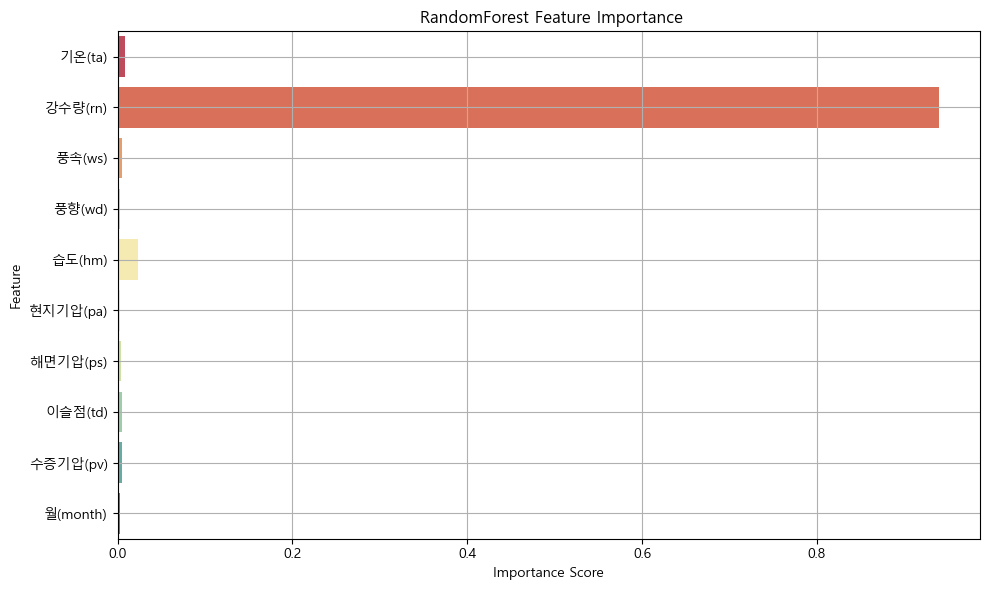

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# 변수 이름 매핑 (순서는 feature_cols와 같아야 함)
feature_labels = [
    '기온(ta)', '강수량(rn)', '풍속(ws)', '풍향(wd)', '습도(hm)',
    '현지기압(pa)', '해면기압(ps)', '이슬점(td)', '수증기압(pv)', '월(month)'
]

# 중요도 추출
importances = model.feature_importances_

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names, palette="Spectral")
plt.title(" RandomForest Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()


# RandomForest 10mm이상 기준 모델 저장하기
# 비만오면 침수예상하는 단순 모델이라 다른 방안 필요

In [18]:
import joblib
joblib.dump(model, 'random_forest_flood_model.pkl')  # 저장
model = joblib.load('random_forest_flood_model.pkl') # 불러오기

# RandomForest 100,200,300,400,500 성능비교

In [4]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# 데이터 로드
df = pd.read_csv('asos_seoul_hourly_labeled.csv')

# 날짜에서 월(month) 추출
df['tm'] = pd.to_datetime(df['tm'])  # 문자열 → datetime 변환
df['month'] = df['tm'].dt.month     # 월만 추출해서 새로운 컬럼 추가

# 특성과 라벨 분리
feature_cols = ['ta', 'rn', 'ws', 'wd', 'hm', 'pa', 'ps', 'td', 'pv', 'month']
X = df[feature_cols]
y = df['flood_risk']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 실험할 n_estimators 값
estimator_list = [10, 50, 100, 200, 300, 500]

# 결과 저장용 리스트
results = []

# 실험 반복
for n in estimator_list:
    print(f"\n Training with n_estimators = {n}")
    start = time.time()
    
    model = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    
    end = time.time()
    elapsed = round(end - start, 2)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results.append({
        'n_estimators': n,
        'accuracy': acc,
        'f1_score': f1,
        'roc_auc': auc,
        'train_time_sec': elapsed
    })

# 결과 DataFrame으로 변환
results_df = pd.DataFrame(results)
print("\n 실험 결과 요약:")
print(results_df)

# 시각화
plt.figure(figsize=(12,6))
plt.plot(results_df['n_estimators'], results_df['accuracy'], label='Accuracy', marker='o')
plt.plot(results_df['n_estimators'], results_df['f1_score'], label='F1 Score', marker='o')
plt.plot(results_df['n_estimators'], results_df['roc_auc'], label='ROC AUC', marker='o')
plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.title('RandomForest 성능 비교')
plt.legend()
plt.grid(True)
plt.show()


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

# 2. 실제 침수 사례 2022년~지금까지 9건 데이터를 넣고 모델학습

# smote 처리를 위한 라이브러리 설치

In [5]:
pip install imbalanced-learn

  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached scikit_learn-1.7.0-cp310-cp310-win_amd64.whl.metadata (14 kB)
  Using cached sklearn_compat-0.1.3-py3-none-any.whl.metadata (18 kB)
  Using cached scikit_learn-1.6.1-cp310-cp310-win_amd64.whl.metadata (15 kB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
Using cached sklearn_compat-0.1.3-py3-none-any.whl (18 kB)
Using cached scikit_learn-1.6.1-cp310-cp310-win_amd64.whl (11.1 MB)

  Attempting uninstall: scikit-learn

    Found existing installation: scikit-learn 1.2.1

   ---------------------------------------- 0/3 [scikit-learn]
    Uninstalling scikit-learn-1.2.1:
   ---------------------------------------- 0/3 [scikit-learn]
      Successfully uninstalled scikit-learn-1.2.1
   ---------------------------------------- 0/3 [scikit-learn]
   ---------------------------------------- 0/3 [scikit-learn]
   ---------------------------------------- 0/3 [scikit-learn]
   ---------------

  You can safely remove it manually.


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 데이터 로드
df = pd.read_csv("asos_seoul_hourly_with_flood_risk.csv")

# 결측치 처리
df['rn'] = df['rn'].fillna(0)
numeric_cols = ['ta', 'ws', 'wd', 'hm', 'pa', 'ps', 'td', 'pv']
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# 월(month) 변수 생성
df['tm'] = pd.to_datetime(df['tm'])
df['month'] = df['tm'].dt.month

# 특성 및 타겟 분리
features = ['ta', 'rn', 'ws', 'wd', 'hm', 'pa', 'ps', 'td', 'pv', 'month']
X = df[features]
y = df['flood_risk']

# 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
proba = model.predict_proba(X_test)
y_proba = proba[:, 1] if proba.shape[1] > 1 else proba[:, 0]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


[[43549     2]
 [   40     3]]
              precision    recall  f1-score   support

           0     0.9991    1.0000    0.9995     43551
           1     0.6000    0.0698    0.1250        43

    accuracy                         0.9990     43594
   macro avg     0.7995    0.5349    0.5623     43594
weighted avg     0.9987    0.9990    0.9987     43594

ROC AUC Score: 0.9508328380572789


# 위에껀 의미없는 모델링 ( 이유 : 테스트셋이 전부 0만 잡힘 )

# SMOTE (test셋에 1을 추가하는 작업 후 모델링하기)

In [5]:
pip install pandas==2.1.1

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

# 1. 데이터 로딩 및 전처리
df = pd.read_csv("asos_seoul_hourly_with_flood_risk.csv")

# 2. 결측치 처리
df['rn'] = df['rn'].fillna(0)
numeric_cols = ['ta', 'ws', 'wd', 'hm', 'pa', 'ps', 'td', 'pv']
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# 3. 월(month) 파생 변수 생성
df['tm'] = pd.to_datetime(df['tm'])
df['month'] = df['tm'].dt.month

# 4. 입력/출력 변수 설정
features = ['ta', 'rn', 'ws', 'wd', 'hm', 'pa', 'ps', 'td', 'pv', 'month']
X_full = df[features]
y_full = df['flood_risk']

# 5. 클래스 비율 확인
print(" 전체 클래스 분포:\n", y_full.value_counts())

# 6. flood_risk=1 너무 적으면 balanced 데이터셋 생성
positive = df[df['flood_risk'] == 1]
negative = df[df['flood_risk'] == 0]
negative_sample = negative.sample(n=len(positive) * 10, random_state=42)  # 클래스 균형 맞추기
df_balanced = pd.concat([positive, negative_sample])

X = df_balanced[features]
y = df_balanced['flood_risk']

# 7. train/test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 8. SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 9. 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# 10. 예측 및 평가
y_pred = model.predict(X_test)
proba = model.predict_proba(X_test)
y_proba = proba[:, 1] if proba.shape[1] > 1 else proba[:, 0]

print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print("\n ROC AUC Score:", roc_auc_score(y_test, y_proba))


 전체 클래스 분포:
 0    217751
1       216
Name: flood_risk, dtype: int64
 Confusion Matrix:
 [[621  27]
 [  2  63]]

 Classification Report:
               precision    recall  f1-score   support

           0     0.9968    0.9583    0.9772       648
           1     0.7000    0.9692    0.8129        65

    accuracy                         0.9593       713
   macro avg     0.8484    0.9638    0.8950       713
weighted avg     0.9697    0.9593    0.9622       713


 ROC AUC Score: 0.9905982905982906


```
Confusion Matrix:
[[TN=621, FP=27],
 [FN=2,  TP=63]]
FN=2 → 놓친 침수 2건 (거의 없음)
FP=27 → 비침수인데 침수로 잘못 예측한 경우 → 모델이 민감하게 반응한 듯

모델 성능 요약
지표	설명
Accuracy	0.96 이상 — 전체 예측 정확도 높음
Precision (1)	0.70 — 침수 예측 시 실제 침수일 확률
Recall (1)	0.97 — 실제 침수일을 거의 다 맞춤 (거의 놓치지 않음!)
F1-score (1)	0.81 — precision과 recall의 균형 좋음
ROC AUC	0.99 — 모델 분류 성능 최고 수준
```

# 시각화하기

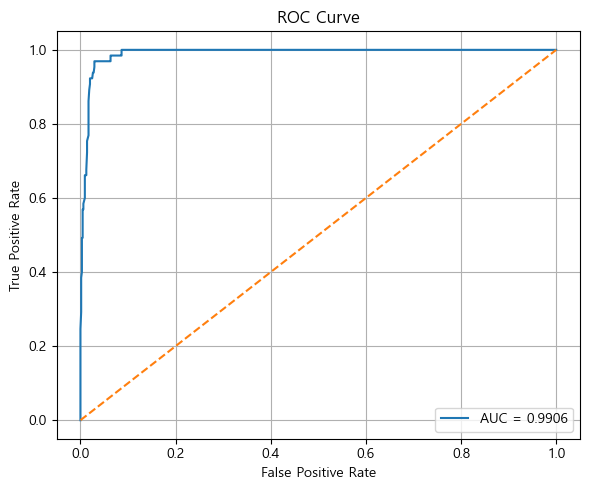

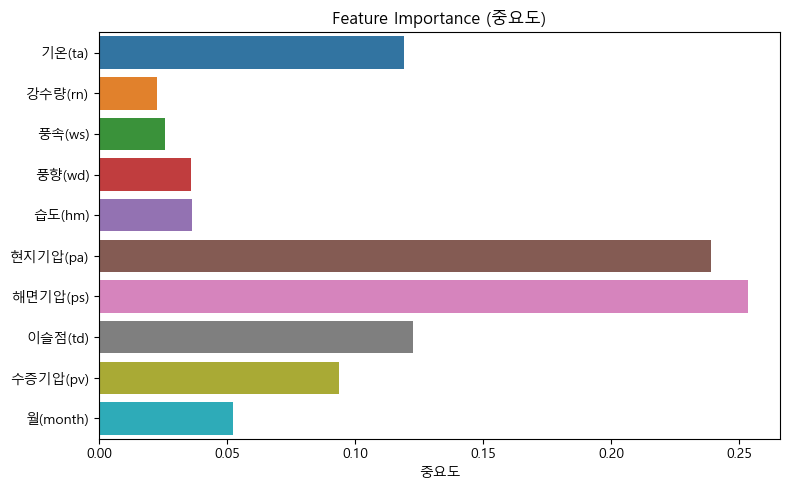

In [5]:
from sklearn.metrics import roc_curve
import seaborn as sns

# 9. ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# 10. Feature Importance 시각화
importances = model.feature_importances_
feature_labels = [
    '기온(ta)', '강수량(rn)', '풍속(ws)', '풍향(wd)', '습도(hm)',
    '현지기압(pa)', '해면기압(ps)', '이슬점(td)', '수증기압(pv)', '월(month)'
]

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_labels)
plt.title("Feature Importance (중요도)")
plt.xlabel("중요도")
plt.tight_layout()
plt.show()

# 모델 저장 및 로드하기 

In [15]:
import joblib

# 모델 저장
joblib.dump(model, 'random_forest_flood_model.pkl')
print(" 모델이 'random_forest_flood_model.pkl'로 저장되었습니다.")

 모델이 'random_forest_flood_model.pkl'로 저장되었습니다.


In [16]:
# 모델 불러오기
loaded_model = joblib.load('random_forest_flood_model.pkl')

# 예측 테스트
y_pred_loaded = loaded_model.predict(X_test)
print(" 불러온 모델로 예측 완료:", y_pred_loaded[:5])


 불러온 모델로 예측 완료: [0 0 0 0 0]


In [ ]:
'''
 Feature Importance 시각화

 Confusion Matrix + Precision/Recall 시각화

 Flask API로 연결
'''